In [1]:
# !pip install gdown # Если еще не установлена

# import gdown

# https://drive.google.com/drive/folders/1FoAF8Zcc2dIjN9qPbva2uTGlGy1HrVcu?usp=sharing

# file_id = 'YOUR_GOOGLE_DRIVE_FILE_ID' # Замените на ID вашего файла
# output_path = 'your_file_name.zip' # Или другое расширение

# gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)


# import os
# print("Текущая рабочая директория:", os.getcwd())
# print("Содержимое текущей директории:", os.listdir('.'))

In [2]:
import os

# допустим, у тебя есть путь: /content/my_project/data
target_dir = "/kaggle/working/ConDiff/ConDiff-main"
#target_dir = "/kaggle/input/condiff/ConDiff-main/architectures"
# создаём путь, если нужно
os.makedirs(target_dir, exist_ok=True)

# переходим в папку
os.chdir(target_dir)

# теперь ты как будто находишься в /content/my_project/data
print("Текущая рабочая директория:", os.getcwd())


Текущая рабочая директория: /kaggle/working/ConDiff/ConDiff-main


In [3]:
import os
print("Текущая рабочая директория:", os.getcwd())
print("Содержимое текущей директории:", os.listdir('.'))

Текущая рабочая директория: /kaggle/working/ConDiff/ConDiff-main
Содержимое текущей директории: []


In [4]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython import display
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython import display
import numpy as np
import os
import sys


In [5]:
sys.path.append("/kaggle/input/condiff/ConDiff-main")
from load_ConDiff import load_ConDiff

In [6]:
# теперь ты как будто находишься в /content/my_project/data
print("Текущая рабочая директория:", os.getcwd())

Текущая рабочая директория: /kaggle/working/ConDiff/ConDiff-main


In [7]:



class AFNO2D(nn.Module):
    def __init__(self, hidden_size, num_blocks=8, sparsity_threshold=0.01, hard_thresholding_fraction=1.0, ffn_factor=1):
        super().__init__()
        assert hidden_size % num_blocks == 0, "hidden_size must be divisible by num_blocks"

        self.hidden_size = hidden_size
        self.num_blocks = num_blocks
        self.block_size = hidden_size // num_blocks
        self.sparsity_threshold = sparsity_threshold
        self.hard_thresholding_fraction = hard_thresholding_fraction
        self.ffn_factor = ffn_factor
        self.scale = 0.02

        # Complex-valued weights for each block (real + imag parts)
        self.w1 = nn.Parameter(self.scale * torch.randn(2, num_blocks, self.block_size, self.block_size * ffn_factor))
        self.b1 = nn.Parameter(self.scale * torch.randn(2, num_blocks, self.block_size * ffn_factor))
        self.w2 = nn.Parameter(self.scale * torch.randn(2, num_blocks, self.block_size * ffn_factor, self.block_size))
        self.b2 = nn.Parameter(self.scale * torch.randn(2, num_blocks, self.block_size))

        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        B, N, C = x.shape
        H = W = int(N ** 0.5)
        assert H * W == N, "Input must be square spatial size"
        x = x.view(B, H, W, C)

        # 1. FFT по пространственным осям
        x_fft = torch.fft.rfft2(x, dim=(1, 2), norm="ortho")  # [B, H, Wf, C]
        x_real, x_imag = x_fft.real, x_fft.imag
        B, H, Wf, C = x_real.shape
        kept_modes = int(Wf * self.hard_thresholding_fraction)

        x_real = x_real[:, :, :kept_modes, :]
        x_imag = x_imag[:, :, :kept_modes, :]

        # 2. Разделение по блокам каналов
        x_real_blocks = x_real.view(B, H, kept_modes, self.num_blocks, self.block_size)
        x_imag_blocks = x_imag.view(B, H, kept_modes, self.num_blocks, self.block_size)

        # 3. Комплексное линейное преобразование: два слоя
        w1_real, w1_imag = self.w1[0], self.w1[1]  # [num_blocks, block_size, block_size * ffn_factor]
        b1_real, b1_imag = self.b1[0], self.b1[1]

        w2_real, w2_imag = self.w2[0], self.w2[1]
        b2_real, b2_imag = self.b2[0], self.b2[1]

        # reshape for matmul: (B*H*Wf, num_blocks, block_size)
        x_real_blocks = x_real_blocks.reshape(-1, self.num_blocks, self.block_size)
        x_imag_blocks = x_imag_blocks.reshape(-1, self.num_blocks, self.block_size)
        #print("x_real_blocks.shape:", x_real_blocks.shape)
        #print("w1_real.shape:", w1_real.shape)
        #print("b1_real.shape:", b1_real.shape)


        # [67584, 4, 24] → [4, 67584, 24]
        x_real_blocks = x_real_blocks.permute(1, 0, 2)
        x_imag_blocks = x_imag_blocks.permute(1, 0, 2)

        # First complex matmul
        o1_real = torch.bmm(x_real_blocks, w1_real) - torch.bmm(x_imag_blocks, w1_imag) + b1_real.unsqueeze(1)
        o1_imag = torch.bmm(x_real_blocks, w1_imag) + torch.bmm(x_imag_blocks, w1_real) + b1_imag.unsqueeze(1)

        o1_real = F.relu(o1_real)
        o1_imag = F.relu(o1_imag)

        # Second complex matmul
        o2_real = torch.bmm(o1_real, w2_real) - torch.bmm(o1_imag, w2_imag) + b2_real.unsqueeze(1)
        o2_imag = torch.bmm(o1_real, w2_imag) + torch.bmm(o1_imag, w2_real) + b2_imag.unsqueeze(1)

        # Back to shape [67584, 4, 24]
        o2_real = o2_real.permute(1, 0, 2)
        o2_imag = o2_imag.permute(1, 0, 2)

        o2_real = o2_real.permute(1, 0, 2).contiguous().view(B, H, kept_modes, self.num_blocks * self.block_size)
        o2_imag = o2_imag.permute(1, 0, 2).contiguous().view(B, H, kept_modes, self.num_blocks * self.block_size)



        # 4. Спектральная маска + возвращение в комплексную форму
        x_fft_out = torch.fft.rfft2(x, dim=(1, 2), norm="ortho")
        x_fft_out.real[:, :, :kept_modes, :] = F.softshrink(o2_real, self.sparsity_threshold)
        x_fft_out.imag[:, :, :kept_modes, :] = F.softshrink(o2_imag, self.sparsity_threshold)

        # 5. Обратное FFT
        x_out = torch.fft.irfft2(x_fft_out, s=(H, W), dim=(1, 2), norm="ortho")
        x_out = x_out.view(B, N, C)
        x = x.view(B, N, C)

        return self.norm(x + x_out)


In [8]:
class AFNOModule(nn.Module):
    def __init__(self, hidden_size=64, num_layers=4, ffn_expansion=4, num_blocks=4, sparsity_threshold=0.01, hard_thresholding_fraction=0.75):
        super().__init__()
        self.project_in = nn.Linear(1, hidden_size)

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                AFNO2D(hidden_size=hidden_size, num_blocks=num_blocks, sparsity_threshold=sparsity_threshold),
                nn.LayerNorm(hidden_size),
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size * ffn_expansion),
                    nn.GELU(),
                    nn.Linear(hidden_size * ffn_expansion, hidden_size),
                ),
                nn.LayerNorm(hidden_size)
            ))

        self.project_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.project_in(x)

        for layer in self.layers:
            afno, norm1, ffn, norm2 = layer
            x = norm1(x + afno(x))  # Residual + Norm after AFNO
            x = norm2(x + ffn(x))   # Residual + Norm after FFN

        x = self.project_out(x)
        return x


In [9]:
# import os
# path = "/kaggle/working/ConDiff"
# path = "/kaggle/working/ConDiff"
# try:
#     os.mkdir(os.path.join(path, 'ConDiff'))
# except:
#     pass
# save_dir = os.path.join(path, 'ConDiff')

In [10]:
# теперь ты как будто находишься в /content/my_project/data
print("Текущая рабочая директория:", os.getcwd())


Текущая рабочая директория: /kaggle/working/ConDiff/ConDiff-main


In [11]:
# %cd /kaggle/working/ConDiff

In [12]:
import h5py
import os
import numpy as np


def load_ConDiff(save_dir, pde, grid, covariance="cubic", variance=0.1):
    """
    Helper function for loading ConDiff dataset from local files.

    Parameters
    ----------
    save_dir : str
        Directory containing the ConDiff dataset (should contain 'df/ConDiff' subdirectory).
    pde : {'poisson', 'diffusion'}
        PDE. If `pde` is `poisson`, parameters
        `covariance` and `variance` are ignored.
    covariance : {'cubic', 'exponential', 'gaussian'}, default 'cubic'
        Covariance model for Gaussian random field (GRF).
        The Diffusion coefficient `k` is generated as: k = exp(GRF).
    variance : {0.1, 0.4, 1.0, 2.0}, defalut 0.1
        Variance of the Gaussian random field.
    grid : {64, 128}
        Computational grid size.

    Returns
    -------
    train_data : {(rhs_train, x_train), (k_train, rhs_train, x_train)}
        If `pde` is `poisson`, returns (rhs_train, x_train), otherwise
        (k_train, rhs_train, x_train).
    test_data : {(rhs_test, x_test), (k_test, rhs_test, x_test)}
        If `pde` is `poisson`, returns (rhs_test, x_test), otherwise
        (k_test, rhs_test, x_test).

    Notes
    -----
    rhs_train, rhs_test : np.ndarray
        Right hand side of the PDE with shape=(num_samples, grid**2)
        for the subset train\test.
    x_train, x_test : np.ndarray
        Solution of the PDE with shape=(num_samples, grid**2) for the
        subset train\tets.
    k_train, k_test : np.ndarray
        Diffusion coefficient with shape=(num_samples, grid+1, grid+1)
        for the subset train/test.
    """
    assert os.path.isdir(save_dir)
    assert pde in ["poisson", "diffusion"]
    assert covariance in ["cubic", "exponential", "gaussian"]
    assert str(variance) in ["0.1", "0.4", "1.0", "2.0"]
    assert str(grid) in ["64", "128"]

    if pde == "poisson":
        name = "poisson_grid" + str(grid)
    else:
        name = covariance + str(variance) + "_grid" + str(grid)

    base_path = os.path.join(save_dir, "df", "ConDiff", name)
    train_path = os.path.join(base_path, name + "_train.h5")
    test_path = os.path.join(base_path, name + "_test.h5")

    assert os.path.exists(train_path), f"Train file not found at {train_path}"
    assert os.path.exists(test_path), f"Test file not found at {test_path}"

    hf_train = h5py.File(train_path, "r")
    hf_test = h5py.File(test_path, "r")

    if pde == "poisson":
        rhs_train, x_train = hf_train["rhs"][:], hf_train["x"][:]
        rhs_test, x_test = hf_test["rhs"][:], hf_test["x"][:]
        train_data = (rhs_train, x_train)
        test_data = (rhs_test, x_test)
    else:
        k_train, rhs_train, x_train = (
            hf_train["k"][:],
            hf_train["rhs"][:],
            hf_train["x"][:],
        )
        k_test, rhs_test, x_test = hf_test["k"][:], hf_test["rhs"][:], hf_test["x"][:]
        train_data = (k_train, rhs_train, x_train)
        test_data = (k_test, rhs_test, x_test)

    hf_train.close()
    hf_test.close()
    return train_data, test_data


In [ ]:
# save_dir="data"

In [14]:
sys.path.append("/kaggle/input/condiff/ConDiff-main//data/df/ConDiff/poisson_grid64")

In [15]:
import os

# допустим, у тебя есть путь: /content/my_project/data
target_dir = "/kaggle/input/condiff/ConDiff-main/data/df/ConDiff/poisson_grid64"
#target_dir = "/kaggle/input/condiff/ConDiff-main/architectures"
# создаём путь, если нужно
os.makedirs(target_dir, exist_ok=True)

# переходим в папку
os.chdir(target_dir)

# теперь ты как будто находишься в /content/my_project/data
print("Текущая рабочая директория:", os.getcwd())


Текущая рабочая директория: /kaggle/input/condiff/ConDiff-main/data/df/ConDiff/poisson_grid64


In [16]:
import os
print("Текущая рабочая директория:", os.getcwd())
print("Содержимое текущей директории:", os.listdir('.'))

Текущая рабочая директория: /kaggle/input/condiff/ConDiff-main/data/df/ConDiff/poisson_grid64
Содержимое текущей директории: ['poisson_grid64_test.h5', 'poisson_grid64_train.h5']


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython import display
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def relative_l2(pred, target):
    return torch.norm(pred - target) / torch.norm(target)
# === Загрузка данных ===
grid = 64
train_data, test_data = load_ConDiff(save_dir="/kaggle/input/condiff/ConDiff-main/data", pde="poisson", grid=64)
rhs_train, x_train = train_data
rhs_test, x_test = test_data

# Преобразование
rhs_train = torch.tensor(rhs_train, dtype=torch.float32).unsqueeze(-1)
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(-1)
rhs_test = torch.tensor(rhs_test, dtype=torch.float32).unsqueeze(-1)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(-1)

train_loader = DataLoader(TensorDataset(rhs_train, x_train), batch_size=4, shuffle=True)
test_loader = DataLoader(TensorDataset(rhs_test, x_test), batch_size=4)


model = AFNOModule(hidden_size=96).to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#loss_fn = nn.MSELoss()

# === История лоссов ===
history_train = []
history_test = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
#loss_fn = relative_l2(pred, target)

history_train = []
history_test = []

num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for rhs, target in train_loader:
        rhs, target = rhs.to(device), target.to(device)
        pred = model(rhs)
        loss = relative_l2(pred, target)
        loss.backward()
        optimizer.step()
        model.zero_grad(set_to_none=True)
        running_loss += loss.item()
    history_train.append(running_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
        for rhs, target in test_loader:
            rhs, target = rhs.to(device), target.to(device)
            pred = model(rhs)
            loss = relative_l2(pred, target)
            total_test_loss += loss.item()
        history_test.append(total_test_loss / len(test_loader))

    scheduler.step()  # 💡 шаг уменьшения LR
    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {history_train[-1]:.4e} | Test Loss: {history_test[-1]:.4e}")


Using device: cuda
Epoch 1/400 | Train Loss: 7.6647e+01 | Test Loss: 1.6484e+01
Epoch 2/400 | Train Loss: 2.5862e+01 | Test Loss: 2.5010e+01
Epoch 3/400 | Train Loss: 1.5599e+01 | Test Loss: 1.8244e+00
Epoch 4/400 | Train Loss: 9.5772e+00 | Test Loss: 7.3489e+00
Epoch 5/400 | Train Loss: 1.0690e+01 | Test Loss: 6.1474e+00
Epoch 6/400 | Train Loss: 7.1601e+00 | Test Loss: 8.9529e+00
Epoch 7/400 | Train Loss: 5.2784e+00 | Test Loss: 5.2220e+00
Epoch 8/400 | Train Loss: 6.2005e+00 | Test Loss: 6.6712e+00
Epoch 9/400 | Train Loss: 4.2390e+00 | Test Loss: 7.3219e+00
Epoch 10/400 | Train Loss: 4.1079e+00 | Test Loss: 9.9414e-01
Epoch 11/400 | Train Loss: 3.6612e+00 | Test Loss: 7.2224e+00
Epoch 12/400 | Train Loss: 3.4056e+00 | Test Loss: 5.9221e+00
Epoch 13/400 | Train Loss: 3.4453e+00 | Test Loss: 4.7001e+00
Epoch 14/400 | Train Loss: 2.8583e+00 | Test Loss: 2.7134e+00
Epoch 15/400 | Train Loss: 3.5475e+00 | Test Loss: 1.1048e+00
Epoch 16/400 | Train Loss: 1.6420e+00 | Test Loss: 1.1196e+0

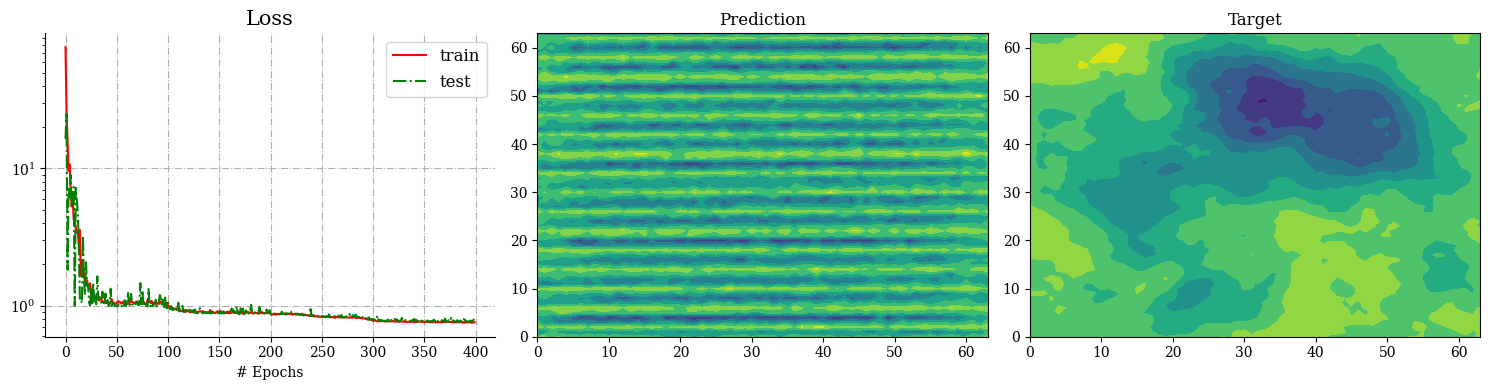

In [18]:
def plot_results(model, data, features_test, targets_test, grid):
    model.eval()
    with torch.no_grad():
        features_test = features_test.to(device)
        targets_test = targets_test.to(device)
        prediction = model(features_test).squeeze(-1).cpu().numpy()
        target = targets_test.squeeze(-1).cpu().numpy()

    display.clear_output(wait=True)

    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    # Loss plot
    ax[0].set_title(r'Loss', fontsize="15")
    ax[0].set_yscale('log')
    ax[0].set_xlabel(r'# Epochs')
    ax[0].plot(data['history_train'], linestyle='-', color='red', label='train')
    ax[0].plot(data['history_test'], linestyle='-.', color='green', label='test')
    ax[0].legend(loc='best', fontsize="12")
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].grid(linestyle='-.')

    # Prediction field
    ax[1].contourf(prediction[0].reshape(grid, grid))
    ax[1].set_title(r'Prediction')

    # Target field
    ax[2].contourf(target[0].reshape(grid, grid))
    ax[2].set_title(r'Target')

    plt.tight_layout()
    plt.show()

# === Вызов визуализации ===
plot_results(model, {
    "history_train": history_train,
    "history_test": history_test
}, rhs_test, x_test, grid)

In [19]:
def batched_relative_l2(model, loader):
    model.eval()
    errors = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            errors.append(relative_l2(pred, y).item())
    return np.array(errors)

train_errors = batched_relative_l2(model, train_loader)
test_errors = batched_relative_l2(model, test_loader)

train_error_mean = np.mean(train_errors)
train_error_std = np.std(train_errors)
test_error_mean = np.mean(test_errors)
test_error_std = np.std(test_errors)

# === Размер модели ===
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_size = count_parameters(model)

# === Вывод результатов ===
print("\n=== Итоговая статистика ===")
print(f"Model size: {model_size}")
print(f"Train relative error: {train_error_mean:.3f} ± {train_error_std:.3f}")
print(f"Test relative error: {test_error_mean:.3f} ± {test_error_std:.3f}")


=== Итоговая статистика ===
Model size: 337825
Train relative error: 0.744 ± 0.126
Test relative error: 0.769 ± 0.136
